# House price prediction using Linear Regression (Minimal)

Using the boston housing dataset: https://www.kaggle.com/c/boston-housing/

- [Dataset & Data loaders](#data)
- [Model](#model)
- [Training](#training)
- [Prediction](#prediction)
- [Save model](#save)


<div id='xx' />

In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# Hyperparameters
batch_size = 64
learning_rate = 5e-7


# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "boston_housing.csv"
TARGET_COLUMN = "medv"
input_size = 13
output_size = 1

<div id='data' />

## Dataset & Data loaders

In [3]:
# Download the data
download_url(DATASET_URL, "../data/", filename=DATA_FILENAME)
dataframe = pd.read_csv("../data/" + DATA_FILENAME)
dataframe.head()

0it [00:00, ?it/s]

40960it [00:00, 101140.33it/s]           


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop("medv", axis=1).values
targets = dataframe[["medv"]].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [5]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size * 2)

<div id='model' />

## Model

In [6]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {"val_loss": loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {"val_loss": epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result["val_loss"]))
    
model = HousingModel()

<div id='training' />

## Training

In [7]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
result = evaluate(model, val_loader)
result

{'val_loss': 22930.244140625}

In [9]:
history = fit(10, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 374.1524
Epoch [1], val_loss: 165.4383
Epoch [2], val_loss: 164.7288
Epoch [3], val_loss: 150.2841
Epoch [4], val_loss: 144.1750
Epoch [5], val_loss: 144.3191
Epoch [6], val_loss: 150.7921
Epoch [7], val_loss: 155.2518
Epoch [8], val_loss: 155.7409
Epoch [9], val_loss: 155.9578


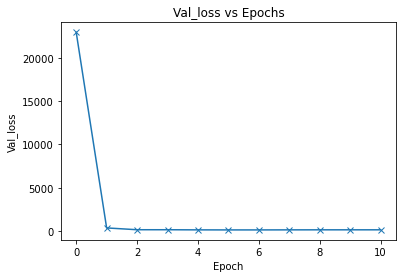

In [10]:
losses = [r["val_loss"] for r in [result] + history]
plt.plot(losses, "-x")
plt.xlabel("Epoch")
plt.ylabel("Val_loss")
plt.title("Val_loss vs Epochs");

<div id='prediction' />

## Prediction

In [11]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [12]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 41.5292,   0.0000,  18.1000,   0.0000,   0.6930,   5.5310,  85.4000,
          1.6074,  24.0000, 666.0000,  20.2000, 329.4600,  27.3800])
Target:  8.5
Prediction: 10.997960090637207


<div id='save' />

## Save and upload

In [13]:
torch.save(model.state_dict(), "models/housing-linear.pth")